In [1]:

####################################################################################################
####################################################################################################

import sys
import os

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint
import time
#import zipfile
#import zlib

from IPython.display import display

#
sys.path.append(os.path.abspath("../"))
from pax_utils import pax_utils
from pax_utils import pulse_utils

#
sys.path.append(os.path.abspath("../pax"))
from pax import plugin

#
sys.path.append(os.path.abspath("../jcalven/ddwave"))
#from plugins.PulseProperties import PulseProperties
#from plugins import FaxIO
#from plugins import ReconFaxWaveform


In [2]:

####################################################################################################
####################################################################################################

ver            = 'v180223'
nEventsPerFile = 1000
nFilesZip      = 2

nEventsPerFile = 3
nFilesZip      = 1

#dir_input    = './pax_output/Feb26/'
dir_input    = './'

dir_format   = dir_input + "instructions_" + ('[0-9]' * 6)
file_format  = 'XENON1T-0-000000000-000000999-000001000.zip'
file_pkl     = 'merged/merged_pax_' + ver + '.pkl'
lst_contents = glob.glob(dir_format)

if (nFilesZip == -1):
    
    nFilesZip    = len(lst_contents)

print()
print("PAX input files: " + str(nFilesZip))
print()



####################################################################################################
####################################################################################################

df_all      = pd.DataFrame()
df_wfs      = pd.DataFrame()
df_wf_sum   = pd.DataFrame()
df_chan_all = pd.DataFrame()

for iZip in range(0, nFilesZip):
        
    ################################################################################################
    ################################################################################################
    
    file = lst_contents[iZip] + '/' + file_format
    
    if (not os.path.exists(file)):
        
        print("Error! File: '" + str(file) + "' does not exist.")
    
        continue
        
    print("File: '" + str(file) + "'")
        
    
    ################################################################################################
    # Reconstructed Quantities to Add:
    #    - S2 waveforms per PMT, S2 electrons, Energy
    ################################################################################################
    
    df_zip, event, df_wf_sum, df_chan = pax_utils.readPaxEventsFromZipFile(file, nEventsPerFile, False)
    
    df_all      = df_all.append(df_zip)
    df_chan_all = df_chan_all.append(df_chan)
    
    display(df_chan)
    
     
    ####################################################################################################
    ## Select Number of Interactions
    ####################################################################################################

    interactions = event.interactions

    if (len(interactions) > 0):
        
        intr0 = interactions[0]

    else:
        
        continue

      
    if (event.n_pulses != len(event.pulses)):
        
        raise()
      
    ##################################################################################################
    ##################################################################################################
    
    #getFullWaveform(event)

     
 
        
    ##################################################################################################
    # Get pulses from main S2
    ##################################################################################################
    
    if (not event.main_s2): continue
       
    #df_test = df_test.append(df_pulses_all)
  
    #print("S2 pulse candidates: " + str(df_pulses_s2.shape[0]))
    
   
    
    
    #################################################################################################
    #################################################################################################
    
    #break
    continue


####################################################################################################
####################################################################################################

#display(df_test)


####################################################################################################
####################################################################################################

df_all.reset_index(inplace=True, drop=True)
df_all['event_number'] = df_all.index


####################################################################################################
####################################################################################################

nEventsPax = df_all.shape[0]

print()
print("PAX Events: " + str(nEventsPax))
print()

if (nEventsPax != nFilesZip * nEventsPerFile):
    
    print()
    print(" -> Error! nEventsPax != nFilesZip * nEventsPerFile")
    print()



PAX input files: 1

File: './instructions_000000/XENON1T-0-000000000-000000999-000001000.zip'

Event:        0
Interactions: 0
Total Pulses: 258
S2 pulse candidates: 58

Event:        1
Interactions: 1
Total Pulses: 414
S2 pulse candidates: 108

Event:        2
Interactions: 0
Total Pulses: 164
S2 pulse candidates: 57


,event
0,0
1,1
2,2



PAX Events: 3



In [3]:

####################################################################################################
####################################################################################################

#df_chan_all.reset_index(drop=True, inplace=True)
display(df_chan_all)


,event
0,0
1,1
2,2


In [8]:

####################################################################################################
####################################################################################################

#print()
#print(df_all.columns)
#display(df_all[:][0:10])
#print()


In [ ]:

df_single  = df_all[df_all['interactions'] == 1]
arr_single = df_single[:]['event_pulse_count'].as_matrix()

print(df_single.shape)
print(np.mean(arr_single))
print(np.std(arr_single))

#display(df_single)

plt.hist(arr_single)

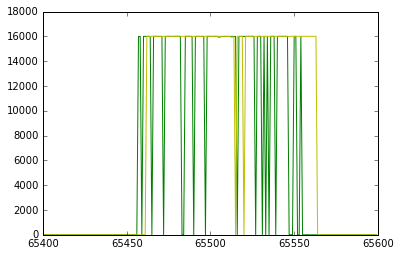

In [29]:

i0 = 65400
i1 = 65600

df_wfs.replace(0.0, 16000, inplace=True)
df_wfs -= 16000
df_wfs *= -1
      
for i in range(0, 127):
    
    arr = df_wfs.iloc[i0:i1, i]

    plt.plot(arr)


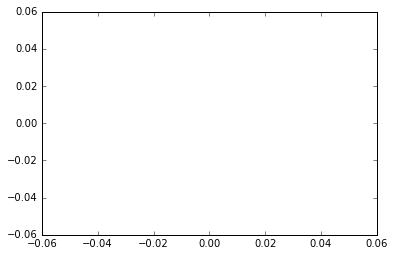

In [7]:

plt.plot(lst_wf[0])
#plt.yscale("log")
#plt.xlim([65400, 65600])
#plt.ylim([78000, 81000])
    

In [ ]:

####################################################################################################
# Write
####################################################################################################

print(file_pkl)

df_all.to_pickle(file_pkl)



In [4]:

####################################################################################################
####################################################################################################

df_all = pd.read_pickle(file_pkl)
df_s2s = df_all[df_all['s2_exists'] == True]

nEvents   = df_all.shape[0]
nEventsS2 = df_s2s.shape[0]
missing   = float(nEvents) - float(nEventsS2)
frac      = round(100*(missing / nEvents), 2)

print(str(int(missing)) + " of " + str(nEvents) + " (" + str(frac) + "%) events missing main S2")



14 of 2000 (0.7%) events missing main S2


In [ ]:


def compute_pulse_properties(w, baseline_samples):
    """Compute basic pulse properties quickly
    :param w: Raw pulse waveform in ADC counts
    :param baseline_samples: number of samples to use for baseline computation at the start of the pulse
    :return: (baseline, baseline_increase, noise_sigma, min, max);
      baseline is the average of the first baseline_samples in the pulse
      baseline_increase = baseline_after - baseline_before
      min and max relative to baseline
      noise_sigma is the std of samples below baseline
    Does not modify w. Does not assume anything about inversion of w!!
    """
    # Compute the baseline before and after the self-trigger
    baseline = 0.0
    baseline_samples = min(baseline_samples, len(w))
    for x in w[:baseline_samples]:
        baseline += x
    baseline /= baseline_samples

    baseline_after = 0.0
    for x in w[-baseline_samples:]:
        baseline_after += x
    baseline_after /= baseline_samples

    baseline_increase = baseline_after - baseline

    # Now compute mean, noise, and min
    n = 0           # Running count of samples included in noise sample
    m2 = 0          # Running sum of squares of differences from the baseline
    max_a = -1.0e6  # Running max amplitude
    min_a = 1.0e6   # Running min amplitude

    for x in w:
        if x > max_a:
            max_a = x
        if x < min_a:
            min_a = x
        if x < baseline:
            delta = x - baseline
            n += 1
            m2 += delta*(x-baseline)

    if n == 0:
        # Should only happen if w = baseline everywhere
        noise = 0
    else:
        noise = (m2/n)**0.5

    return baseline, baseline_increase, noise, min_a - baseline, max_a - baseline


In [ ]:

#def transform_event(event, transform_raw=None):
def transform_event(pulses, transform_raw=None):
       
        config = {
            "digitizer_reference_baseline": 16000, 
            "baseline_samples": 47,
            "shrink_data_threshold": float('inf')
        }
        
        #if transform_raw is not None:
        #    self.transform_raw = transform_raw
        
        reference_baseline = config['digitizer_reference_baseline']
        
        n_baseline = config.get('baseline_samples', 50)
        
        shrink_data_threshold = config.get('shrink_data_threshold', float('inf'))
        shrink_data_samples   = config.get('shrink_data_samples', n_baseline)

        #n_pulses = len(event.pulses)
        n_pulses = len(pulses)
        
        warning_given = False

        #for pulse_i, pulse in enumerate(event.pulses):
        for pulse_i, pulse in enumerate(pulses):
            
            if not np.isnan(pulse.minimum):
                if not warning_given:
                    print("Pulse properties have already been computed, doing nothing.")
                    warning_given = True
                #return event

            # Retrieve waveform as floats: needed to subtract baseline (which can be in between ADC counts)
            w = pulse.raw_data.astype(np.float64)

            # Subtract reference baseline, invert (so hits point up from baseline)
            # This is convenient so we don't have to reinterpret min, max, etc
            w = reference_baseline - w
            
            _results = compute_pulse_properties(w, n_baseline)
            pulse.baseline, pulse.baseline_increase, pulse.noise_sigma, pulse.minimum, pulse.maximum = _results
            
            # Set the waveform to the modified waveform
            if transform_raw:
                pulse.raw_data = w - pulse.baseline

            if n_pulses > shrink_data_threshold:

                pulse.raw_data = pulse.raw_data[shrink_data_samples:-shrink_data_samples]
                pulse.right -= n_baseline
                pulse.left += n_baseline

        #return event
        return pulses

In [ ]:
 
####################################################################################################
####################################################################################################

def getFullWaveformJakob(event):
    
    
    #################################################################################################
    #################################################################################################
    
    pulses1 = transform_event(event.pulses)

    print("len(pulses): " + str(len(pulses1)))

    if (len(pulses1) > 0):
        
        pulses2 = ReconFaxWaveform.get_pulses([event])
    
        print(pulses2.shape)
        display(pulses2)
    
        df_wfs = ReconFaxWaveform.get_full_event(pulses2)

        print(waveforms_in_channels.shape)
    
    print("---")
    
        
    
    #waveforms_in_channels = ReconFaxWaveform.get_full_event(event, N_PMTS=self.N_PMTS, EVENT_SIZE=self.EVENT_SIZE)
        
        
    #waveforms_in_channels = ReconFaxWaveform.get_full_event(evt_test)
                                                            
    #print("here: " + str(waveforms_in_channels.shape))
    

In [ ]:

####################################################################################################
# From Bart
#
# The S2 of the interaction will have a certain (corrected) energy in pe.
# This can be converted to detected electrons by dividing by the single electron gain.
# Then there is the electron lifetime to get to the number of emitted electrons.
# The total deposited energy depends on a combination of the corrected S1 and corrected S2 in what
# we call the combined energy scale (CES).
#
# Energy calc?
#
# I dont know how the Hitfinder calculates the areas of each hit exactly, but basically its the
# integral of the pulse. Then all areas of all hits in a peak are summed to get the raw energy.
# Then after Interaction pairing any spatially dependent corrections are applied.

# "interactions[0].corrected_s2_area() throws an exception when I try to access it...." 
# I think you might have found a bug there. corrected_s2_area is a property of the Interaction
# class which returns self.s2.area * self.s2_area_correction. But s2 is not the peak but the index
# of the peak. So the correct call would be: self.peaks[self.s2].area. Anyways these python
# properties don't work well with the ROOT event class so when we reduce the data they are recomputed.
# So long story short, the corrected S2 energy for the main interaction is:
#    main_s2 = interactions[0].peaks[interactions[0].s2]
#    cs2 = main_s2.area * main_s2.s2_area_correction
#
# S2?
#
# Indeed, this is encoded in the secondary scintillation gain: s2_secondary_sc_gain = 19.7 pe/electron.
# For a number of simulated electrons extracted into the gas gap a poisson random variate is drawn
# with a mean of s2_secondary_sc_gain * light_yield(x,y). The light yield map is mainly a second order
# effect. So on average you get 19.7 photoelectrons per extracted electron.
#
#
# This is the number of electrons extracted in the gas. So you also have to invert the electron
# livetime correction to get the number of generated electrons
#
# The livetime correction is implemented here:
#    https://github.com/XENON1T/pax/blob/c5424d4ca7905c05bd51b6b161ffda603637e034/pax/simulation.py#L545
#
# Ah sorry I gave you the XENON100 value for the secondary scintillation gain, for XENON1T its 21.3.
#    https://github.com/XENON1T/pax/blob/master/pax/config/XENON1T.ini#L249
#
# https://github.com/XENON1T/pax/blob/master/pax/plugins/interaction_processing/BuildInteractions.py#L122
#   
####################################################################################################

In [4]:

####################################################################################################
# Helsinki
####################################################################################################

cols_helsinki = [
    'event_number',
    'interactions',
    'intr_x',
    'intr_y',
    'intr_xy_posrec_algorithm',
    'intr_xy_posrec_goodness_of_fit']

cols_s2s = df_all.columns[20:]
cols_helsinki.extend(cols_s2s)

df_helsinki = df_all[:][cols_helsinki]

print()
display(df_helsinki[:][0:10])
print()


####################################################################################################
# Write
####################################################################################################

df_helsinki.to_pickle('../helsinki_stockholm_collaboration/data/helsinki_pax_data.pkl')



,event_number,interactions,intr_x,intr_y,intr_xy_posrec_algorithm,intr_xy_posrec_goodness_of_fit,s2_area_000,s2_area_001,s2_area_002,s2_area_003,...,s2_area_117,s2_area_118,s2_area_119,s2_area_120,s2_area_121,s2_area_122,s2_area_123,s2_area_124,s2_area_125,s2_area_126
0,0,0,NaN,NaN,None,NaN,0.000000,0.0,0.0,1.466725,...,2.029469,0.0,1.036413,1.793720,0.000000,0.650330,0.000000,3.199793,0.000000,0.000000
1,1,1,2.867794,-16.333960,PosRecTopPatternFit,149.343971,0.000000,0.0,0.0,0.000000,...,1.275422,0.0,1.452915,1.012572,2.251780,2.828248,35.046942,6.155046,0.690037,4.378836
2,2,0,NaN,NaN,None,NaN,0.000000,0.0,0.0,0.000000,...,0.423072,0.0,0.000000,0.000000,0.000000,0.680948,1.021790,0.000000,2.403017,0.000000
3,3,1,10.348997,-5.860276,PosRecTopPatternFit,184.999796,0.000000,0.0,0.0,1.882222,...,1.266866,0.0,1.913466,3.294025,28.969575,114.923185,34.596442,13.827712,2.696806,15.881756
4,4,0,NaN,NaN,None,NaN,0.000000,0.0,0.0,0.000000,...,2.242011,0.0,1.227137,0.590853,0.000000,0.000000,0.851703,1.083009,0.643391,0.000000
5,5,0,NaN,NaN,None,NaN,0.388025,0.0,0.0,0.000000,...,13.402411,0.0,0.000000,0.000000,0.157323,2.717893,5.092304,1.777208,0.993155,2.617439
6,6,1,1.870301,34.288847,PosRecTopPatternFit,178.716106,7.744014,0.0,0.0,8.837715,...,0.000000,0.0,0.773043,3.192246,2.808413,0.000000,0.000000,1.063054,1.680573,1.336977
7,7,2,-21.072055,-4.613409,PosRecTopPatternFit,257.531000,10.645957,0.0,0.0,0.000000,...,460.904614,0.0,18.440722,12.635315,16.693542,5.798586,14.349123,42.362008,20.279486,13.990620
8,8,1,-16.832707,-21.570802,PosRecTopPatternFit,218.881827,0.000000,0.0,0.0,2.128111,...,10.279197,0.0,12.491381,3.279123,0.000000,2.964916,2.533233,5.906580,2.047196,4.983197
9,9,1,-22.817669,-7.356516,PosRecTopPatternFit,223.444693,2.283322,0.0,0.0,1.695223,...,199.064405,0.0,14.335660,10.281589,9.140659,9.573623,1.563595,24.776068,16.890516,11.718063
